In [209]:
import os
import matplotlib.pyplot as plt
import numpy as np

In [210]:
import re

def parse_oscilloscope_data(input_data):
    data = {
        'time_step': None,
        'voltage_step': None,
        'zero_level': None
    }
    
    patterns = {
        'time_step': r'Time step\s*=\s*([\d,]+)\s*([munpf]?)S',
        'voltage_step': r'Voltage step\s*=\s*([\d,]+)\s*([mun]?)V',
        'zero_level': r'Zero level\s*=\s*([\d,]+)'
    }
    
    unit_multipliers = {
        'n': 1e-9,
        'u': 1e-6,
        'm': 1e-3,
        'p': 1e-12,
        'f': 1e-15,
        '': 1
    }
        
    for line in input_data:
        line = line.strip()
        
        if match := re.search(patterns['time_step'], line, re.IGNORECASE):
            value = float(match.group(1).replace(',', '.'))
            unit = match.group(2).lower()
            data['time_step'] = value * unit_multipliers.get(unit, 1)
        
        elif match := re.search(patterns['voltage_step'], line, re.IGNORECASE):
            value = float(match.group(1).replace(',', '.'))
            unit = match.group(2).lower()
            data['voltage_step'] = value * unit_multipliers.get(unit, 1)
        
        elif match := re.search(patterns['zero_level'], line, re.IGNORECASE):
            value = float(match.group(1).replace(',', '.'))
            data['zero_level'] = value
    
    data["zero_level"] *= data['voltage_step']
    
    return data
        

In [211]:
DIRECTORY = "Lab4_data"

FFT_N = 8192

def plot_osc_spec(name, lines, N, FFT_N, CLIP_FFT_N, markers=[], crop_markers_left=0, crop_markers_right=-1):
    t = []
    x = []
    
    settings = parse_oscilloscope_data(lines[:5])        
    for line in lines:
        if len(line.split("\t")) < 3:
            continue
        try:
            t_i, x_i, _ = list(map(int, line.split("\t")))
        except:
            continue
        
        t.append(t_i * settings["time_step"])
        x.append(x_i)

    t = np.array(t)
    x = np.array(x)
    
    delta_f = 1 / (settings["time_step"] * FFT_N)
    print(settings["time_step"], delta_f)

    plt.figure(figsize=(16, 9))
    print(name)
    plt.xlabel("$t$, мкс")
    plt.ylabel("$U$, В")
    plt.plot(t[:N] * 1e6, x[:N], color="black")
    plt.show()
    
    window = np.array([(1 - np.cos(2 * np.pi * i / (len(x) - 1))) for i in range(len(x))])
    
    X = np.abs(np.fft.fft(x * window, FFT_N))

    X_db = 20 * np.log10(X)

    if len(markers) > 0:
        plt.figure(figsize=(16, 9))
        print(f"FFT with markers, {name}")
        plt.xlabel("$f$, МГц")
        plt.ylabel("$X$, дБ")
        for marker in markers:
            i = int(marker / delta_f * 1e6)
            
            print(crop_markers_left, crop_markers_right)
            
            # delta_i = 15
            delta_i = 15
            print(delta_f, marker, i)
            # print(f"marker: {marker}, value: {np.min(X_db[i - delta_i : i + delta_i])} - {np.max(X_db[i - delta_i : i + delta_i])} дБ")
            plt.axvline(x=marker, color='red', linestyle='--', linewidth=2)
            # plt.axvline(x=(i - delta_i) * 2 * np.pi / settings["time_step"] / 1e12, color='green', linestyle='--', linewidth=2)
            # plt.axvline(x=(i + delta_i) * 2 * np.pi / settings["time_step"] / 1e12, color='green', linestyle='--', linewidth=2)
        crop_markers_left = int(crop_markers_left / delta_f * 1e6)
        crop_markers_right = int(crop_markers_right / delta_f * 1e6)
        plt.plot(np.arange(FFT_N)[crop_markers_left:crop_markers_right] * delta_f / 1e6, X_db[crop_markers_left:crop_markers_right
                                                                                                                         ])
        plt.show()
    
    X = np.abs(np.fft.fft(x, FFT_N))

    plt.figure(figsize=(16, 9))
    print(f"FFT, {name}")
    plt.xlabel("$f$, МГц")
    plt.ylabel("$X$, дБ")
    plt.plot(np.arange(FFT_N)[:CLIP_FFT_N] * delta_f / 1e6, X_db[:CLIP_FFT_N], color="black")
    plt.show()

for filename in os.listdir(DIRECTORY):
    if not filename.endswith('.txt'):
        continue
    filepath = os.path.join(DIRECTORY, filename)
    
    t = []
    x = []
    
    with open(filepath, "r") as f:
        lines = f.readlines()
        settings = parse_oscilloscope_data(lines[:5])        
        # plot_osc_spec(lines, 8000, 8192)

1e-08 12207.03125
1


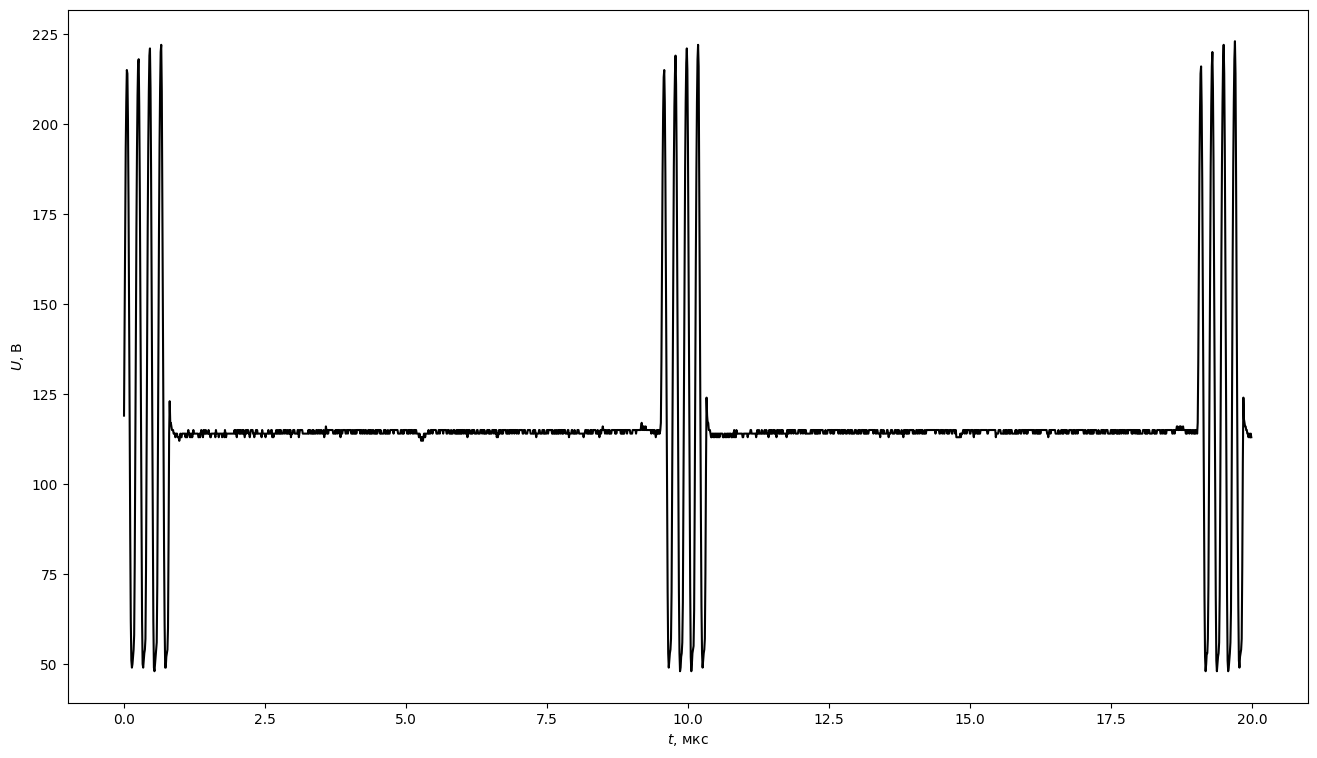

FFT with markers, 1
0 7
12207.03125 1.9 155
0 7
12207.03125 2.5 204
0 7
12207.03125 3.2 262


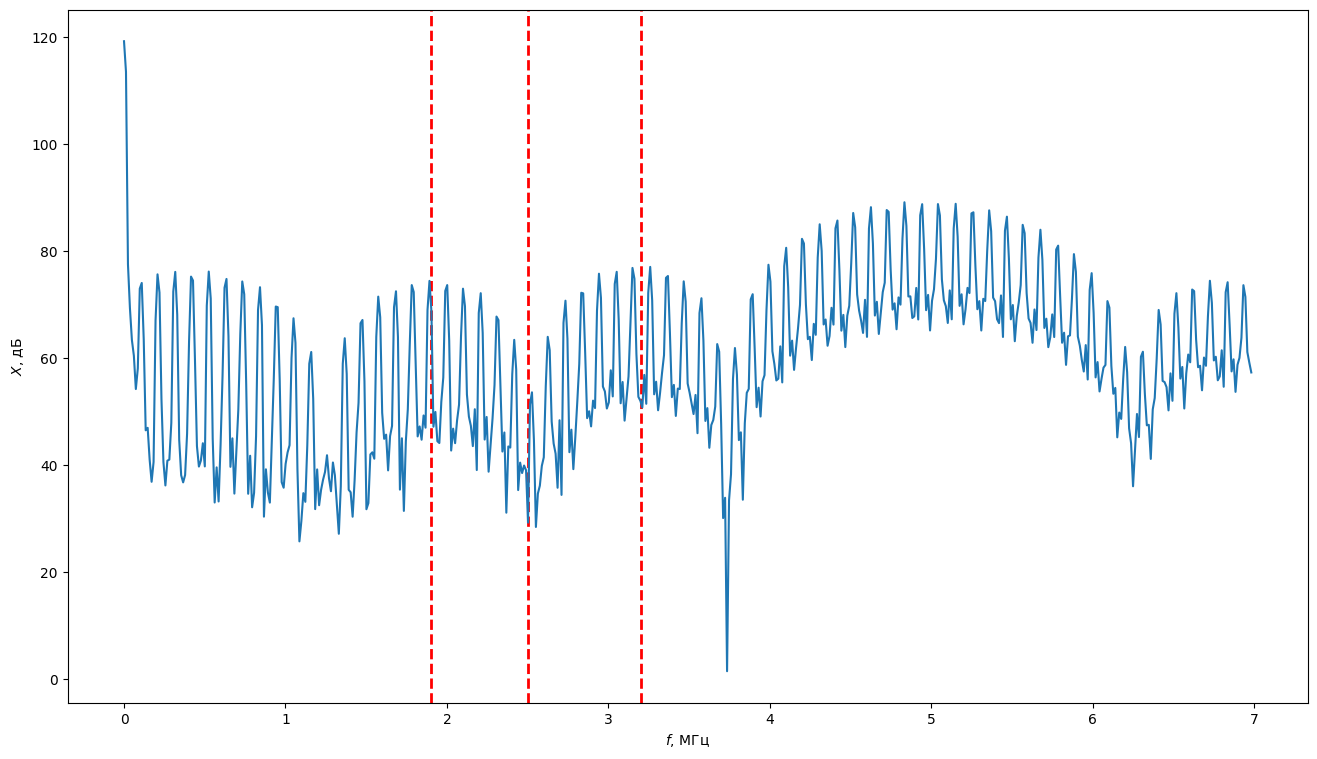

FFT, 1


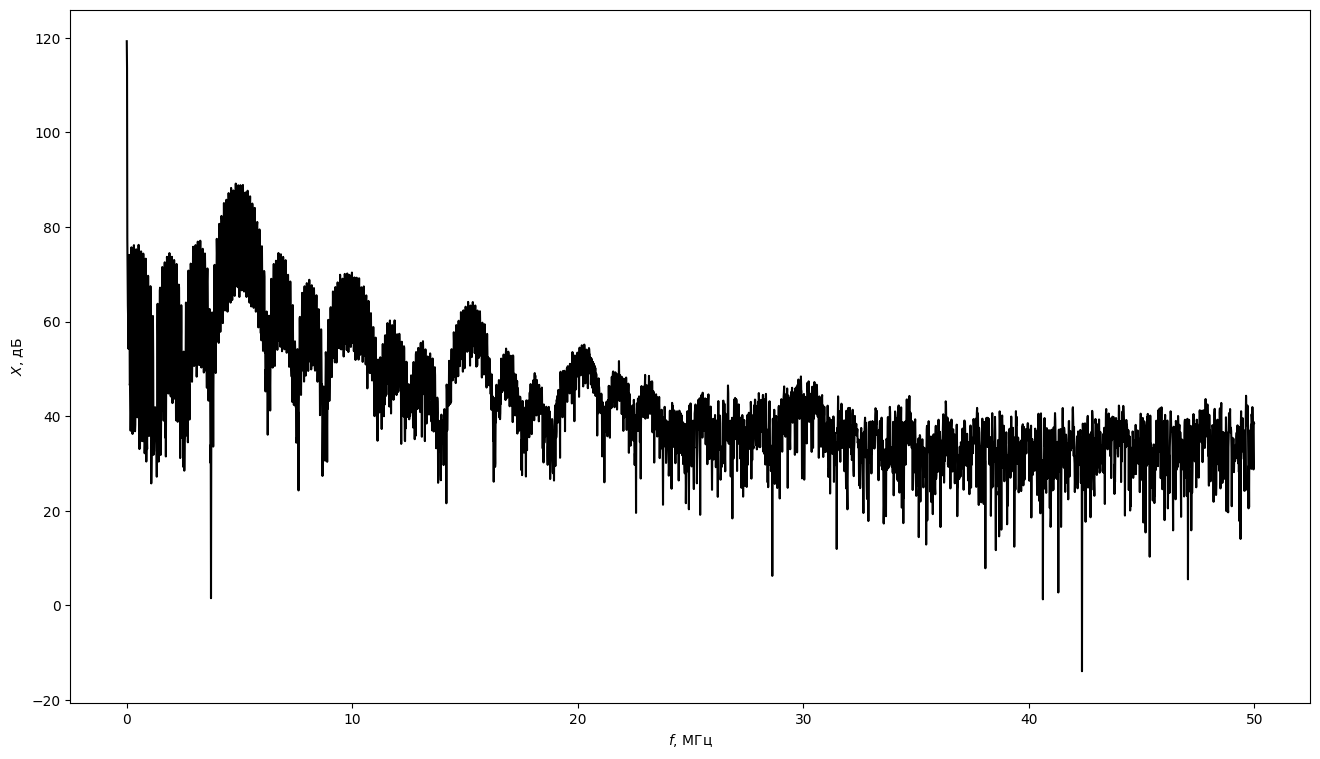

1e-08 12207.03125
2


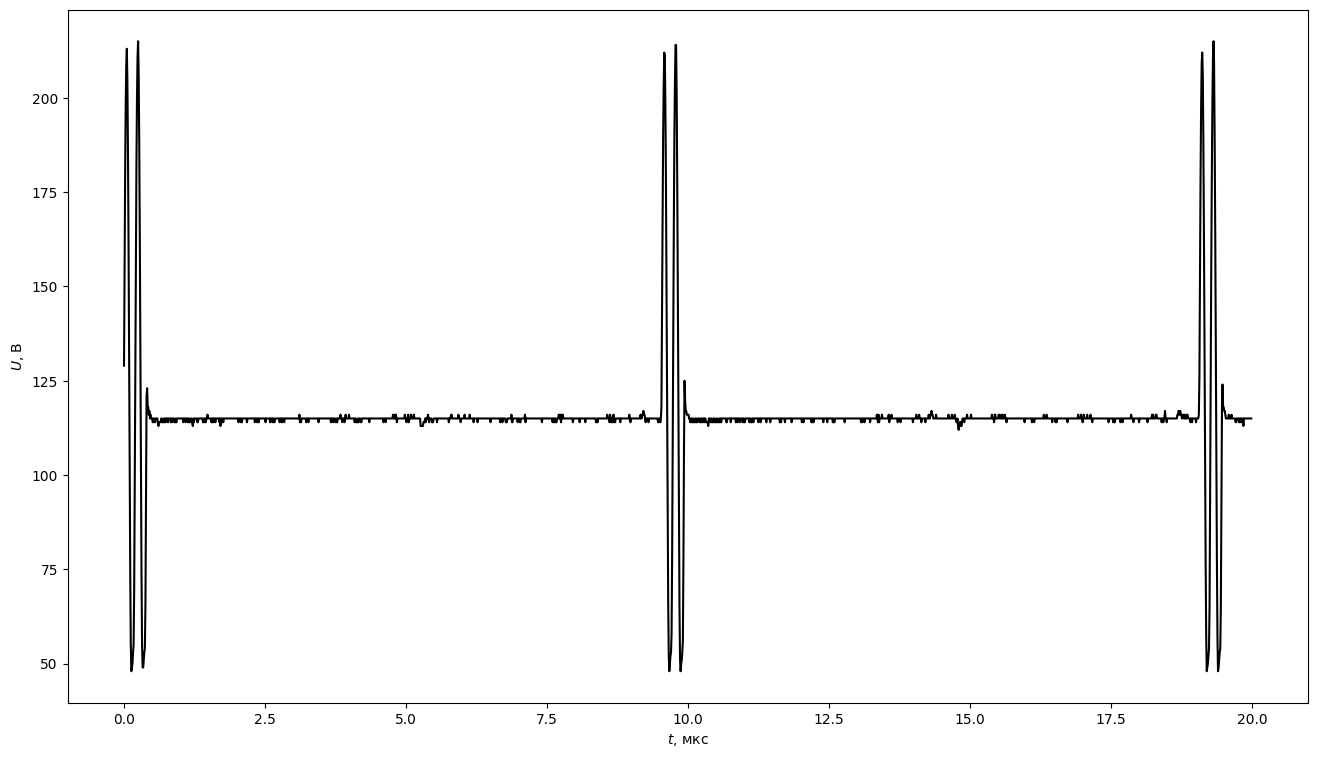

FFT with markers, 2
0 7
12207.03125 1.9 155
0 7
12207.03125 2.5 204
0 7
12207.03125 3.2 262


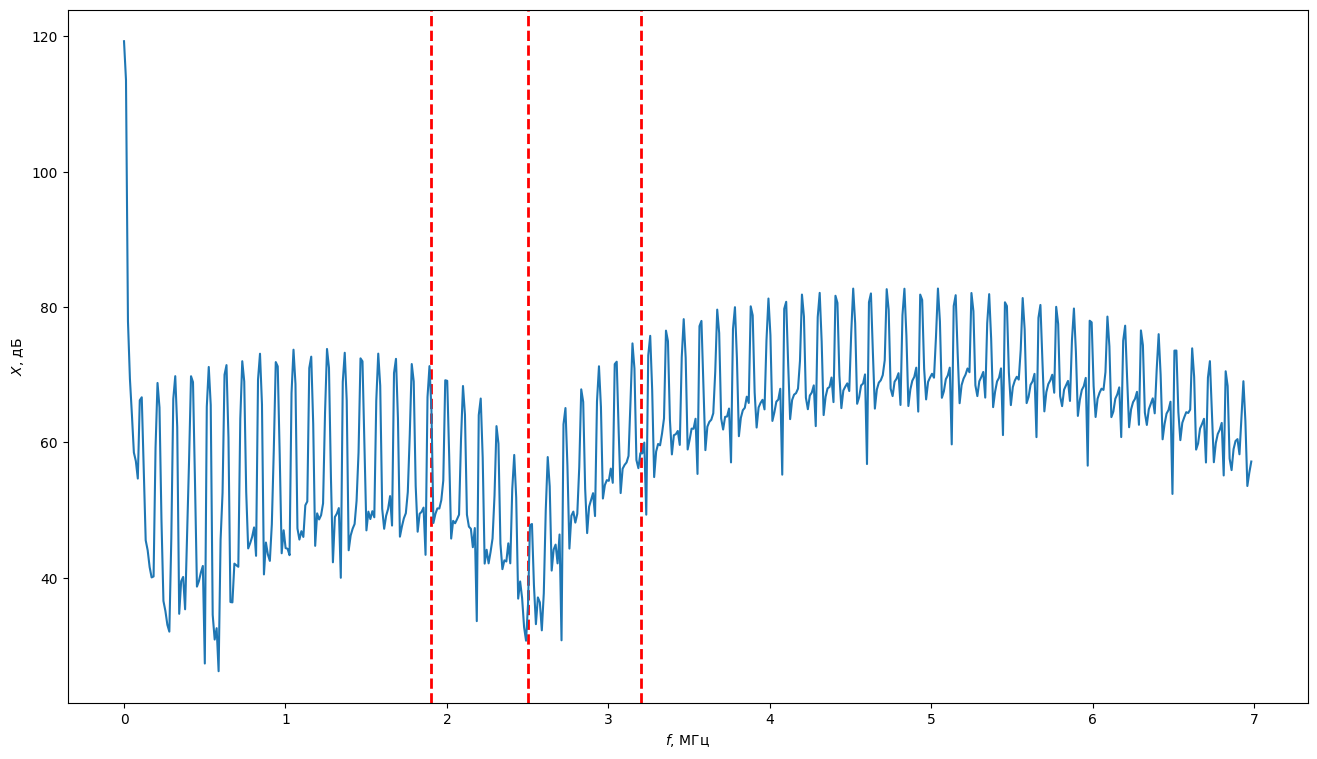

FFT, 2


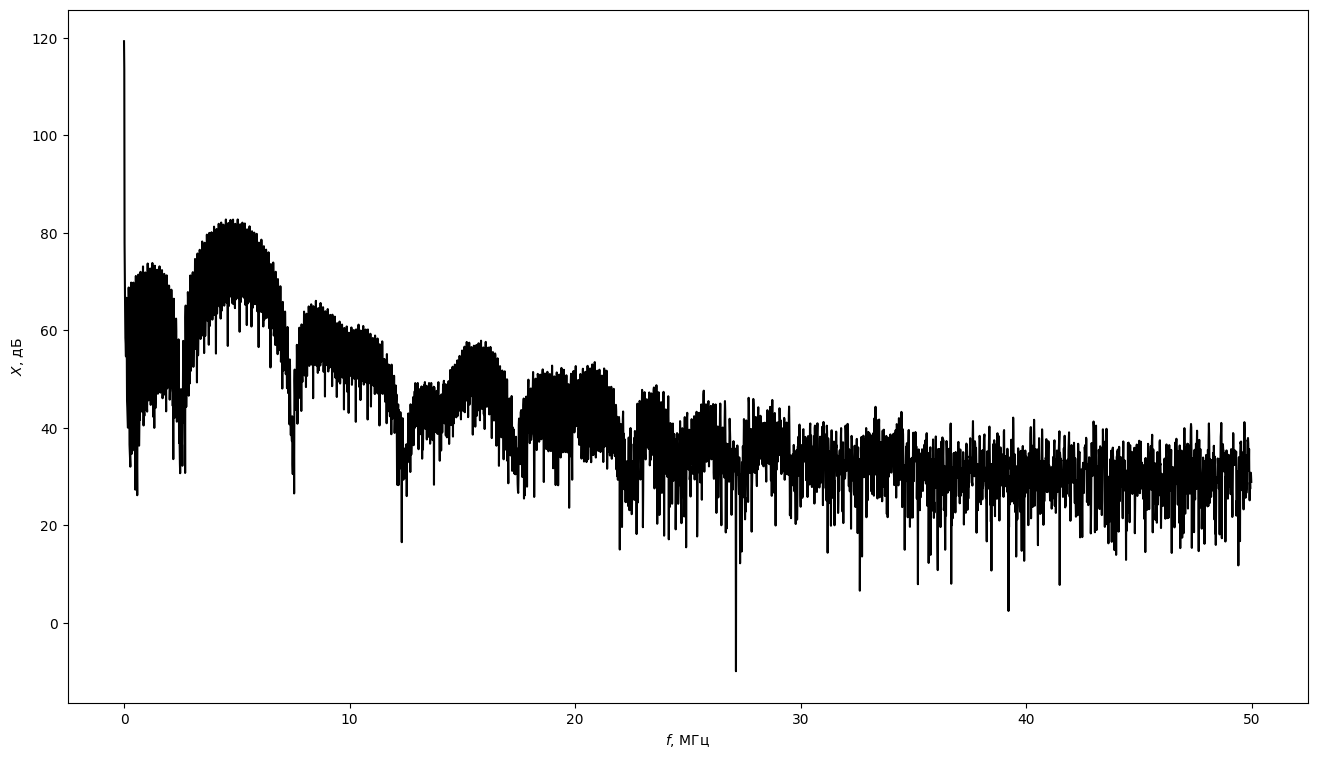

1e-08 12207.03125
3


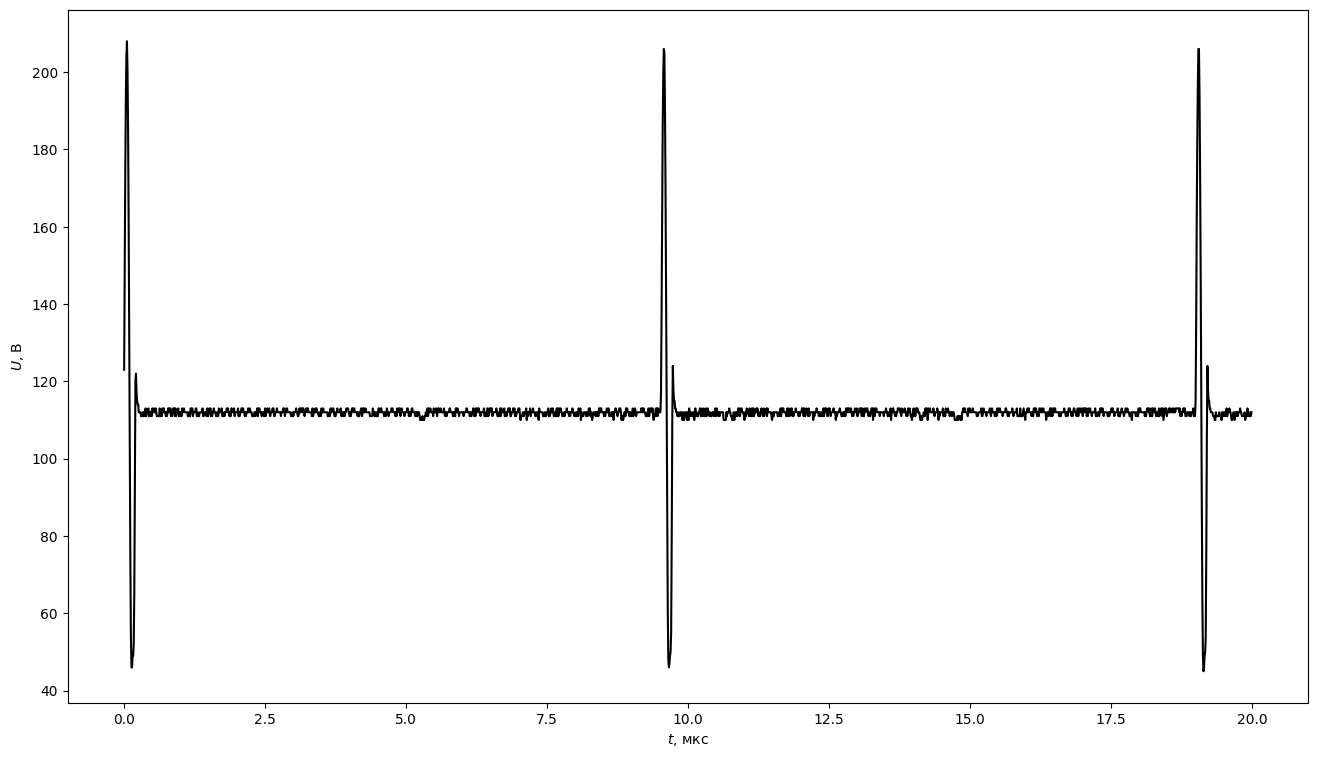

FFT with markers, 3
0 7
12207.03125 1.9 155
0 7
12207.03125 2.5 204
0 7
12207.03125 3.2 262


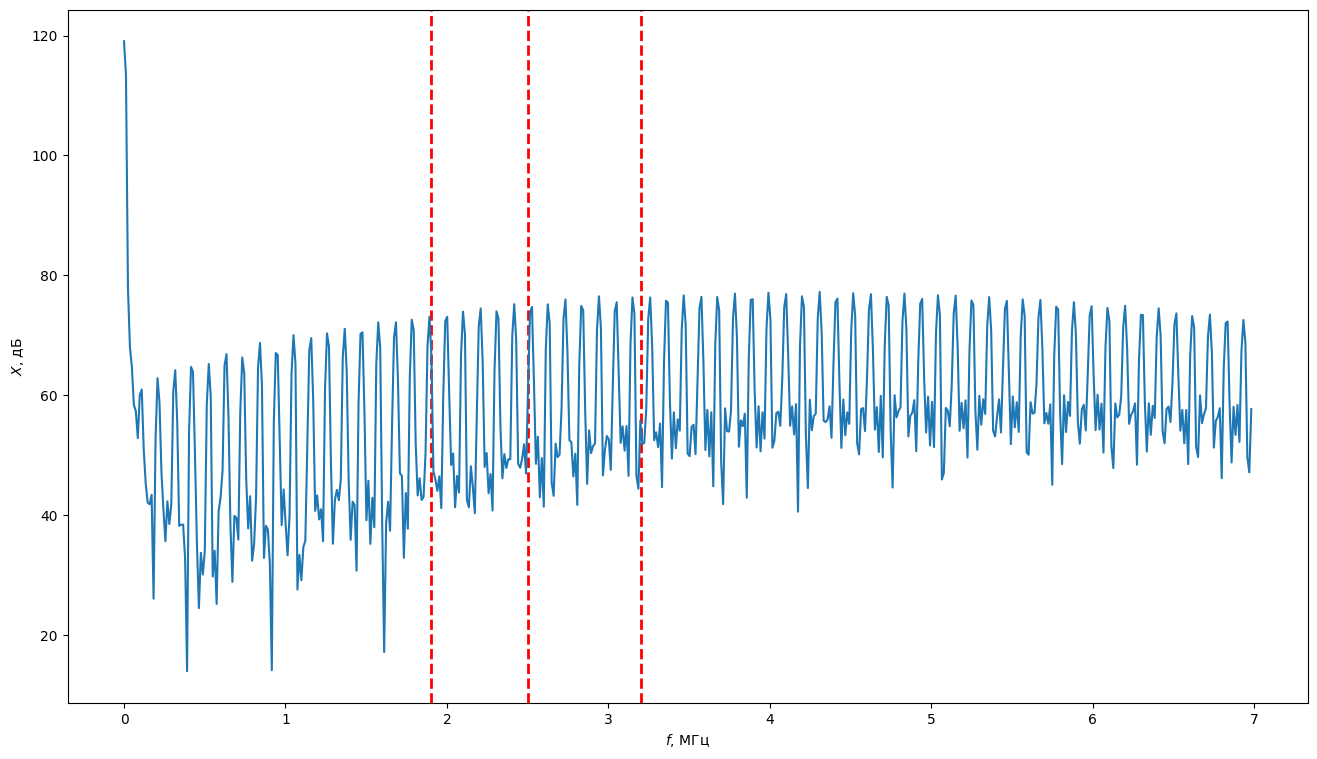

FFT, 3


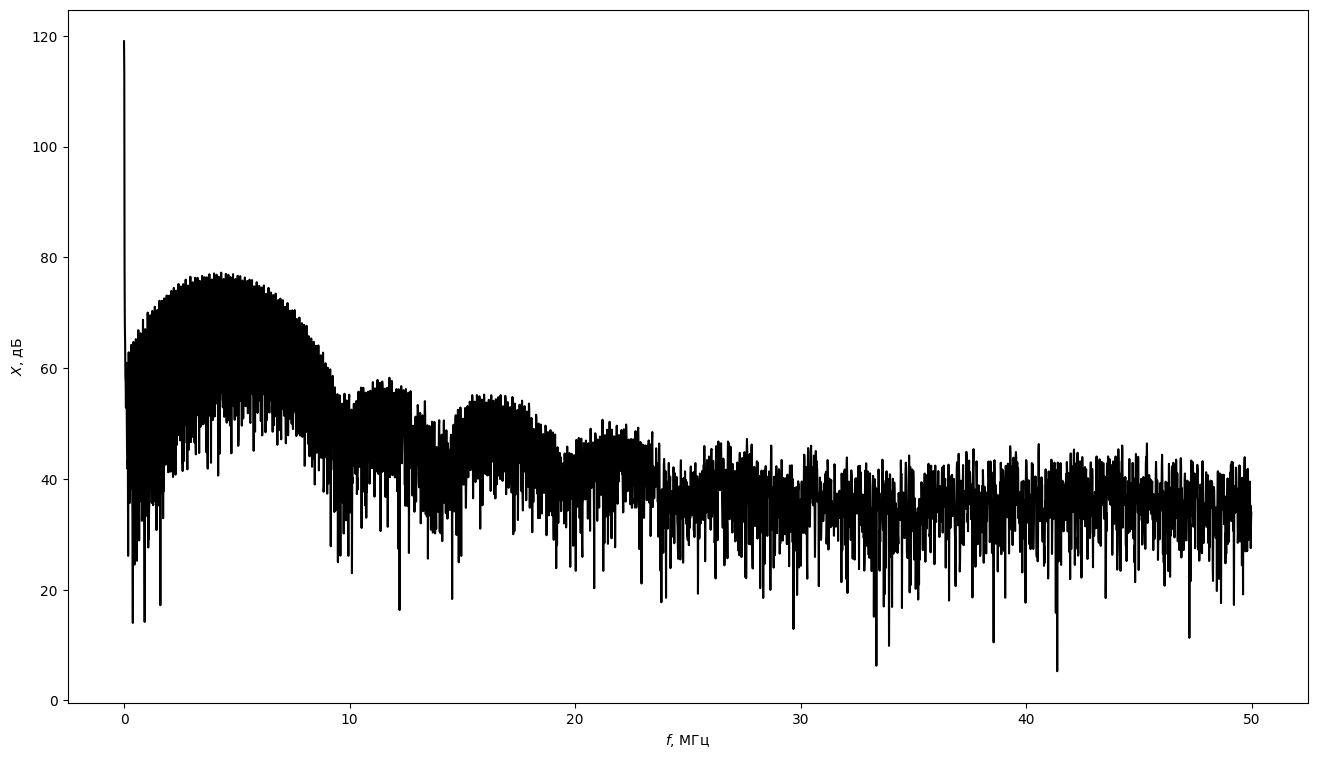

In [212]:
with open("Lab4_data/1_1.txt", "r") as f:
    markers = [1.9, 2.5, 3.2]
    plot_osc_spec("1", f.readlines(), 2000, 8192, 4096, markers, crop_markers_left=0, crop_markers_right=7)

with open("Lab4_data/1_2.txt", "r") as f:
    markers = [1.9, 2.5, 3.2]
    plot_osc_spec("2", f.readlines(), 2000, 8192, 4096, markers, crop_markers_left=0, crop_markers_right=7)

with open("Lab4_data/1_3.txt", "r") as f:
    markers = [1.9, 2.5, 3.2]
    plot_osc_spec("3", f.readlines(), 2000, 8192, 4096, markers, crop_markers_left=0, crop_markers_right=7)

1e-08 12207.03125
2_2


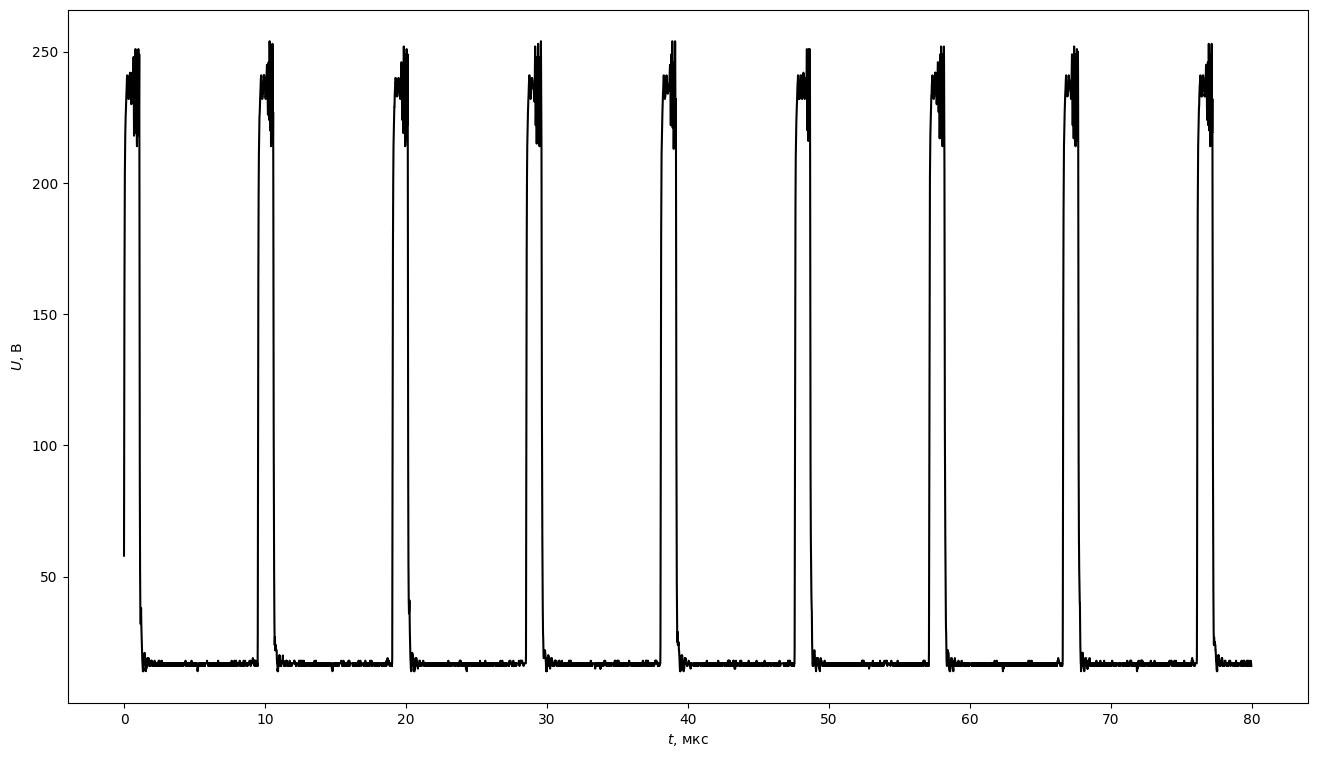

FFT with markers, 2_2
0.5 1.1
12207.03125 0.525 43
0.5 1.1
12207.03125 0.54 44
0.5 1.1
12207.03125 0.56 45
0.5 1.1
12207.03125 0.585 47
0.5 1.1
12207.03125 0.61 49
0.5 1.1
12207.03125 0.635 52
0.5 1.1
12207.03125 0.66 54
0.5 1.1
12207.03125 0.76 62
0.5 1.1
12207.03125 0.9 73
0.5 1.1
12207.03125 0.92 75
0.5 1.1
12207.03125 0.935 76
0.5 1.1
12207.03125 0.96 78
0.5 1.1
12207.03125 0.985 80
0.5 1.1
12207.03125 1.01 82
0.5 1.1
12207.03125 1.035 84


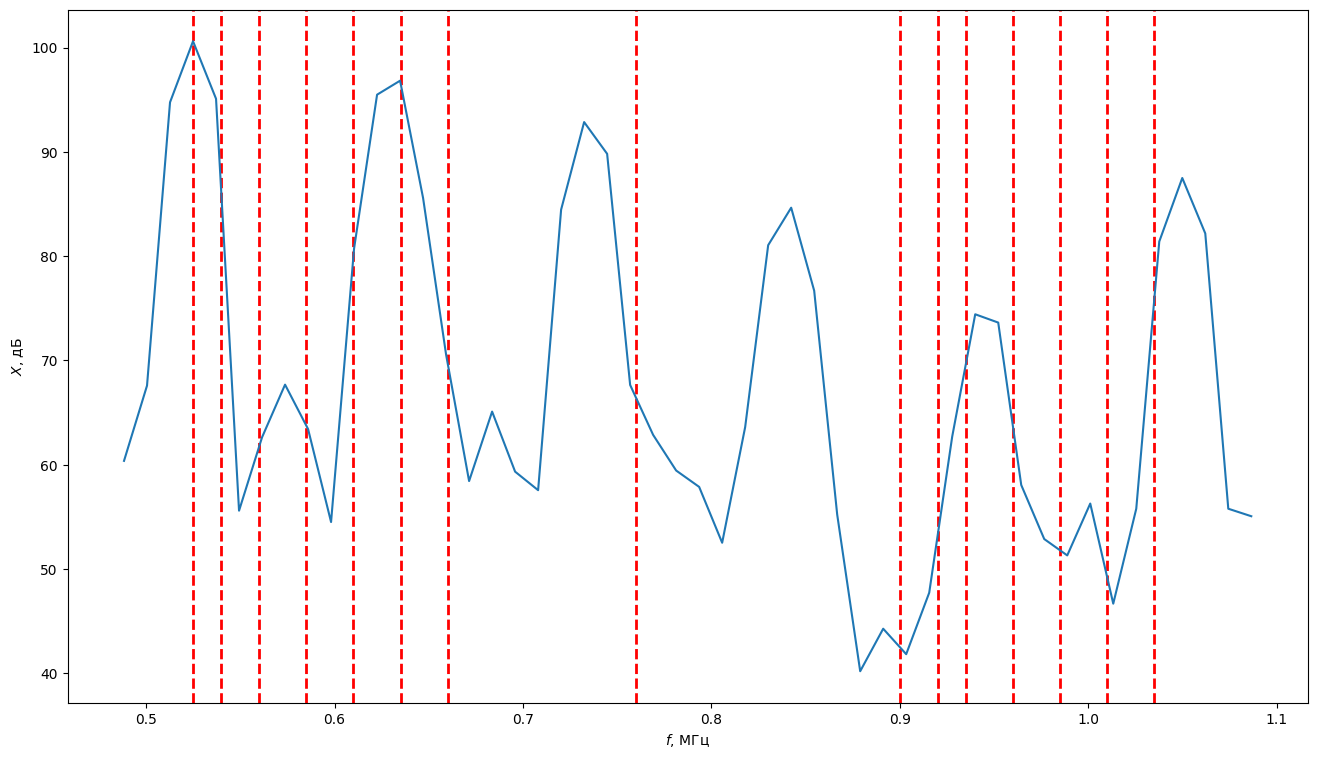

FFT, 2_2


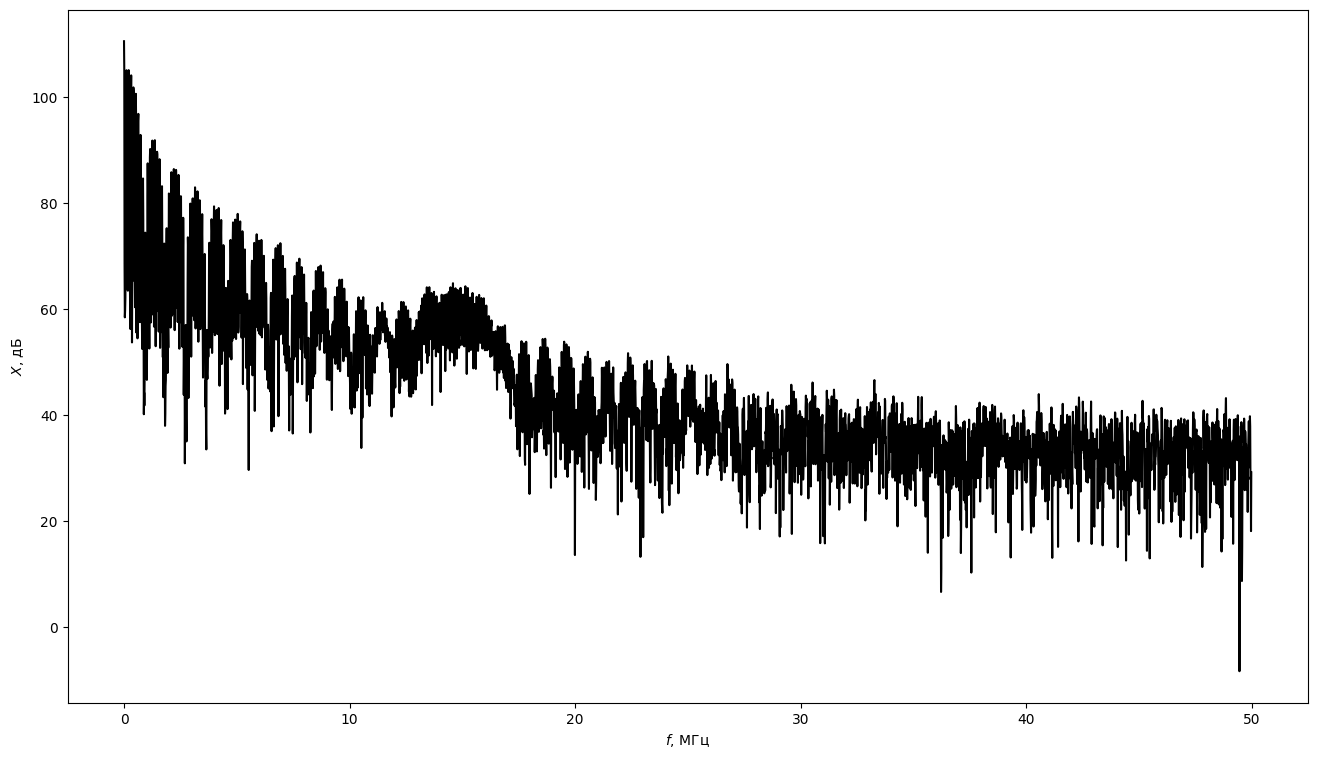

In [213]:
with open("Lab4_data/2_2.txt", "r") as f:
    markers = [0.525, 0.54, 0.56, 0.585, 0.61, 0.635, 0.66, 0.76, 0.90, 0.92, 0.935, 0.96, 0.985, 1.01, 1.035]
    plot_osc_spec("2_2", f.readlines(), -1, 8192, 4096, markers, crop_markers_left=0.5, crop_markers_right=1.1)